Build Chatbot for breast cancer

For answer questions about breast cancer patient

In [3]:
# Load Data
import pandas as pd

df = pd.read_csv("assets/sentences_classes.csv")

# assign sentences and labels
sentences = df['sentences']
y = df['class']

In [5]:
# test printout
print(df.head(5))
print(df.shape)

            sentences   class
0           กินได้ไหม  การกิน
1     กินได้หรือเปล่า  การกิน
2   เมนูกินได้รึเปล่า  การกิน
3    การกินของผู้ป่วย  การกิน
4  กินข้าวอะไรได้บ้าง  การกิน
(1923, 2)


In [57]:
# count classes

# Count occurrences of each class
class_counts = y.value_counts().sort_values(ascending=True)

class_counts_df = pd.DataFrame(class_counts).reset_index()
class_counts_df.columns = ['class', 'count_class']

# number of classes
print("number of classes: ", class_counts_df.shape[0])

class_counts_df

number of classes:  101


,class,count_class
0,วิธีการตรวจหาก้อนเนื้อด้วยตนเอง,10
1,ถุงน้ำ,10
2,เมื่อไหร่ควรตรวจเอกซเรย์เต้านม,10
3,การเอกซเรย์เต้านม,10
4,ทำอย่างไรเมื่อเป็นมะเร็งระยะแรก,10
...,...,...
96,ถ้าปวดเมื่อยตามตัว ปวดศรีษะ ทานยาพาราได้ไหม,45
97,ทานอาหารเสริมหรือวิตามินได้ไหม หลังผ่าตัด,49
98,ฉีดวัคซีนได้ไหม,51
99,อาการหลังการฉายแสง,57


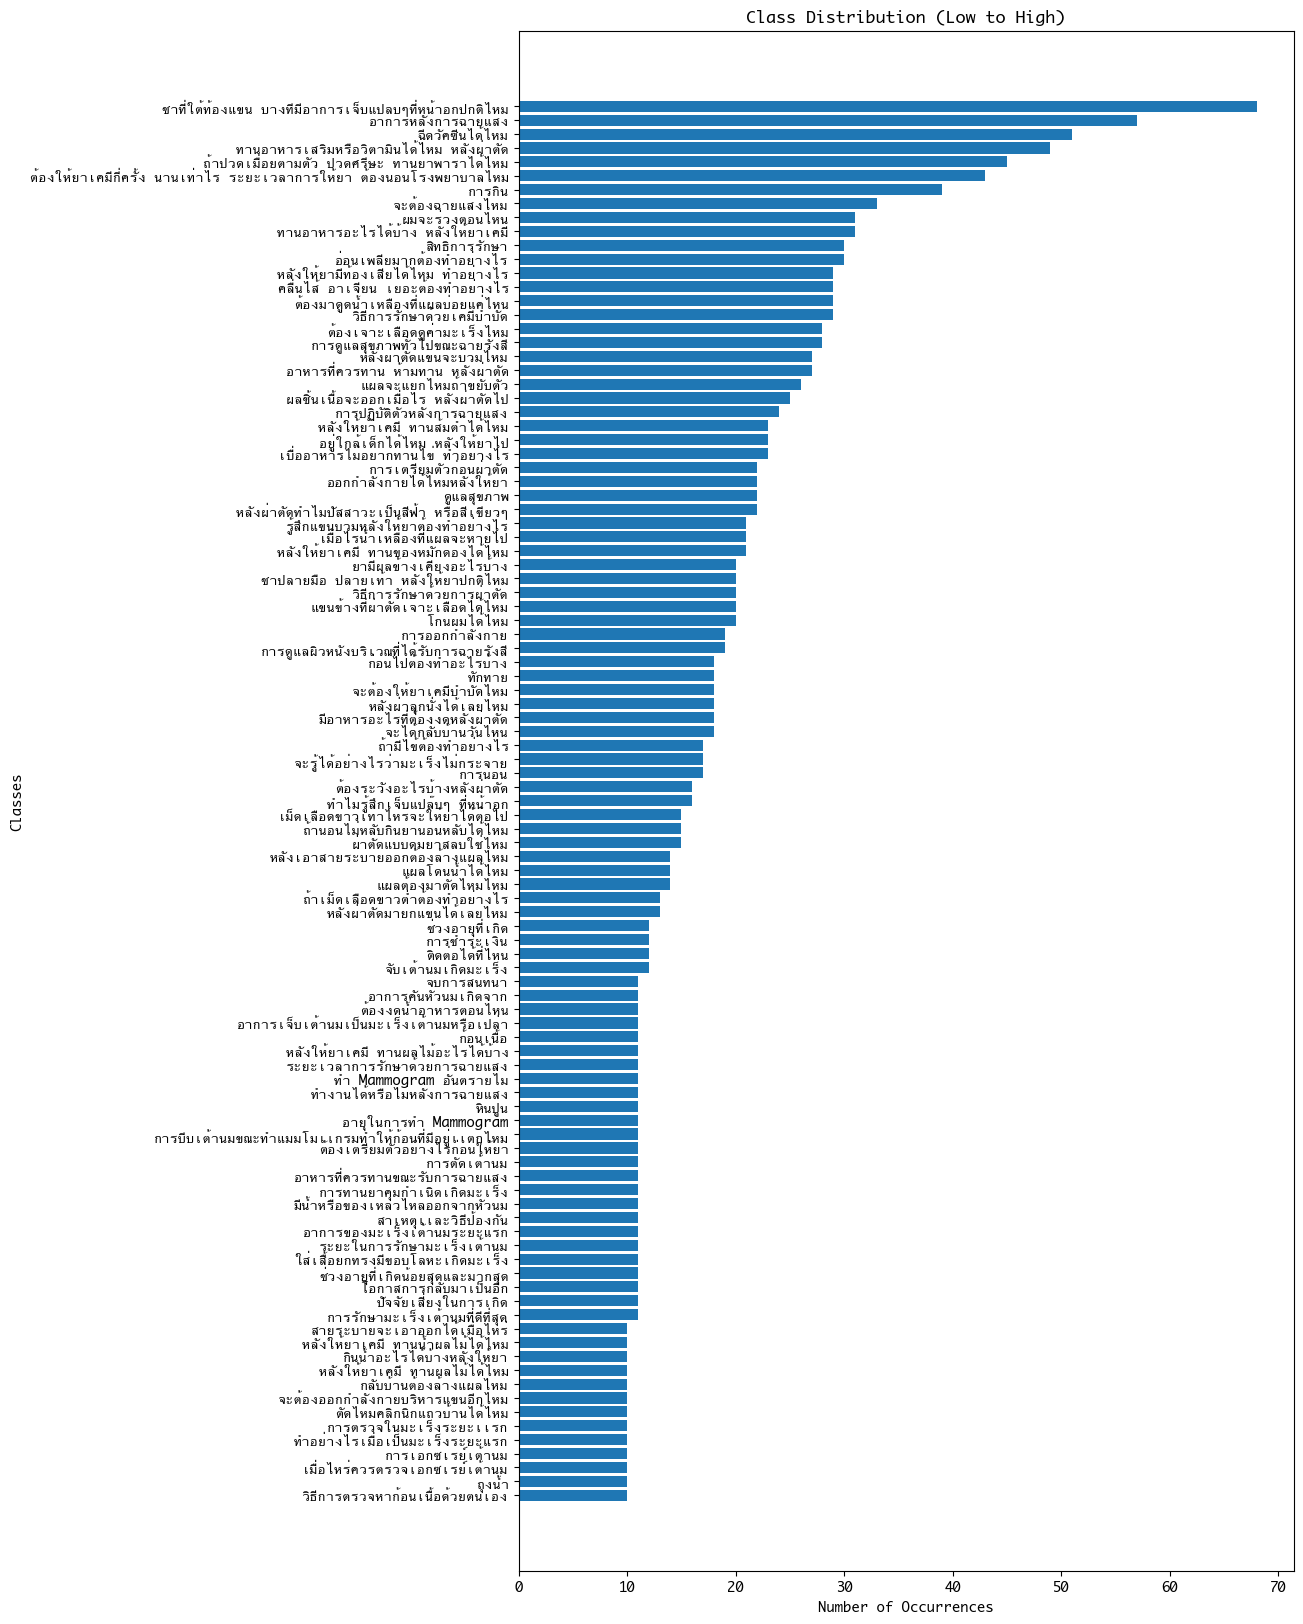

In [54]:
# plot graph
import matplotlib

# Set the font that supports Thai 
matplotlib.rcParams['font.family'] = 'Ayuthaya'

# Plot graph
plt.figure(figsize=(10,20))
plt.barh(class_counts_df['class'], class_counts_df['count_class'])
plt.xlabel('Number of Occurrences')
plt.ylabel('Classes')
plt.title('Class Distribution (Low to High)')
plt.show()

In [55]:
# try build classification model using Bi-LSTM
from pythainlp.tokenize import word_tokenize
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Tokenize Thai text
X_tokenized = df['sentences'].apply(word_tokenize, keep_whitespace=False)

# Step 1: Convert tokens to sequences of integers
word_to_index = {}
index = 1  # Start indexing from 1
for tokens in X_tokenized:
    for word in tokens:
        if word not in word_to_index:
            word_to_index[word] = index
            index += 1

# Convert tokenized sentences into integer sequences
tts = X_tokenized.apply(lambda tokens: [word_to_index[word] for word in tokens])

# Encode Labels
num_classes = len(np.unique(y)) 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert labels to numbers
y_categorical = to_categorical(y_encoded, num_classes=num_classes)  # Convert labels to one-hot encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tts, y_categorical, test_size=0.25, random_state=99)

# Find max length of the sentences for padding
maxlen = max([len(s) for s in tts])
print(f"Max sentence length = {maxlen}")

# Padding sequences to make them the same length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Define model parameters
embedding_dim = 50
vocab_size = len(word_to_index) + 1  # Adding 1 for padding token

# Build Bi-LSTM Model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

# Bidirectional LSTM Layer with Dropout and BatchNormalization
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# GlobalMaxPooling1D to reduce dimensions and keep the important features
model.add(GlobalMaxPooling1D())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (Softmax for classification)
model.add(Dense(num_classes, activation='softmax'))

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Add EarlyStopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=10,
                    validation_data=(X_test, y_test),
                    # callbacks=[early_stopping],
                    verbose=2)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {train_acc:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy: {test_acc:.4f}")


Max sentence length = 23
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


145/145 - 3s - 19ms/step - accuracy: 0.0229 - loss: 4.6396 - val_accuracy: 0.0499 - val_loss: 4.6113
Epoch 2/50
145/145 - 2s - 11ms/step - accuracy: 0.0284 - loss: 4.5579 - val_accuracy: 0.0520 - val_loss: 4.6026
Epoch 3/50
145/145 - 2s - 11ms/step - accuracy: 0.0361 - loss: 4.4865 - val_accuracy: 0.0707 - val_loss: 4.5813
Epoch 4/50
145/145 - 2s - 11ms/step - accuracy: 0.0583 - loss: 4.4025 - val_accuracy: 0.0977 - val_loss: 4.5274
Epoch 5/50
145/145 - 2s - 11ms/step - accuracy: 0.0902 - loss: 4.3068 - val_accuracy: 0.1019 - val_loss: 4.4296
Epoch 6/50
145/145 - 2s - 11ms/step - accuracy: 0.1012 - loss: 4.1852 - val_accuracy: 0.1497 - val_loss: 4.3189
Epoch 7/50
145/145 - 2s - 11ms/step - accuracy: 0.1394 - loss: 4.0422 - val_accuracy: 0.1746 - val_loss: 4.1920
Epoch 8/50
145/145 - 2s - 11ms/step - accuracy: 0.1616 - loss: 3.9004 - val_accuracy: 0.2328 - val_loss: 4.0915
Epoch 9/50
145/145 - 2s - 11ms/step - accuracy: 0.1852 - loss: 3.7062 - val_accuracy: 0.2703 - val_loss: 3.9529
Epo

In [59]:
# train and test result have gap in accuracy due to imbalance of classes
# try data augment to reduce imbalance of classes
# augment data classes have 20 instances and lower

class_counts_df[class_counts_df['count_class']<=20]

,class,count_class
0,วิธีการตรวจหาก้อนเนื้อด้วยตนเอง,10
1,ถุงน้ำ,10
2,เมื่อไหร่ควรตรวจเอกซเรย์เต้านม,10
3,การเอกซเรย์เต้านม,10
4,ทำอย่างไรเมื่อเป็นมะเร็งระยะแรก,10
...,...,...
63,โกนผมได้ไหม,20
64,แขนข้างที่ผ่าตัดเจาะเลือดได้ไหม,20
65,วิธีการรักษาด้วยการผ่าตัด,20
66,ชาปลายมือ ปลายเท้า หลังให้ยาปกติไหม,20


In [61]:
import pandas as pd
# from pythainlp.augment import WordNetAug
from pythainlp.augment.word2vec import Thai2fitAug

# Your existing function to augment sentences
def augment_and_convert_tokens(df, column_name="sentences", label_column="class", num_aug=1):
    """
    Augments sentences, converts augmented tokens to strings, and maps them to classes.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the sentence column to augment.
        label_column (str): The name of the label column.
        num_aug (int): The number of augmented sentences to generate per original sentence.

    Returns:
        pd.DataFrame: A new DataFrame with augmented sentences and labels.
    """
    # aug = WordNetAug()
    aug = Thai2fitAug()
    augmented_sentences = []
    augmented_labels = []

    sentences = df[column_name].tolist()
    y = df[label_column].tolist()

    for sentence, label in zip(sentences, y):
        augmented_sentences.append(sentence)
        augmented_labels.append(label)

        for _ in range(num_aug):
            aug_tokens = aug.augment(sentence)  # get tokens from augment
            for token_pair in aug_tokens:
                joined_token = "".join(token_pair)
                augmented_sentences.append(joined_token)
                augmented_labels.append(label)

    new_df = pd.DataFrame({
        "sentences": augmented_sentences,
        "class": augmented_labels,
    })

    return new_df

# Assuming class_counts_df is already calculated, and you have the original df (e.g. df_low_f1)
# Filter the rows where class count is <= 20
class_counts_df = df['class'].value_counts().reset_index()
class_counts_df.columns = ['class', 'count_class']

# Filter classes with count <= 20
classes_to_augment = class_counts_df[class_counts_df['count_class'] <= 20]['class'].tolist()

# Filter your main dataframe to get sentences belonging to those classes
df_to_augment = df[df['class'].isin(classes_to_augment)]

# Augment the sentences of the filtered dataframe
df_augmented = augment_and_convert_tokens(df_to_augment, num_aug=1)

# Combine the augmented data with the original dataframe
df_final = pd.concat([df, df_augmented], ignore_index=True)

print(f"Original dataframe shape: {df.shape}")
print(f"Augmented dataframe shape: {df_final.shape}")


Original dataframe shape: (1923, 2)
Augmented dataframe shape: (3713, 2)


number of classes:  101


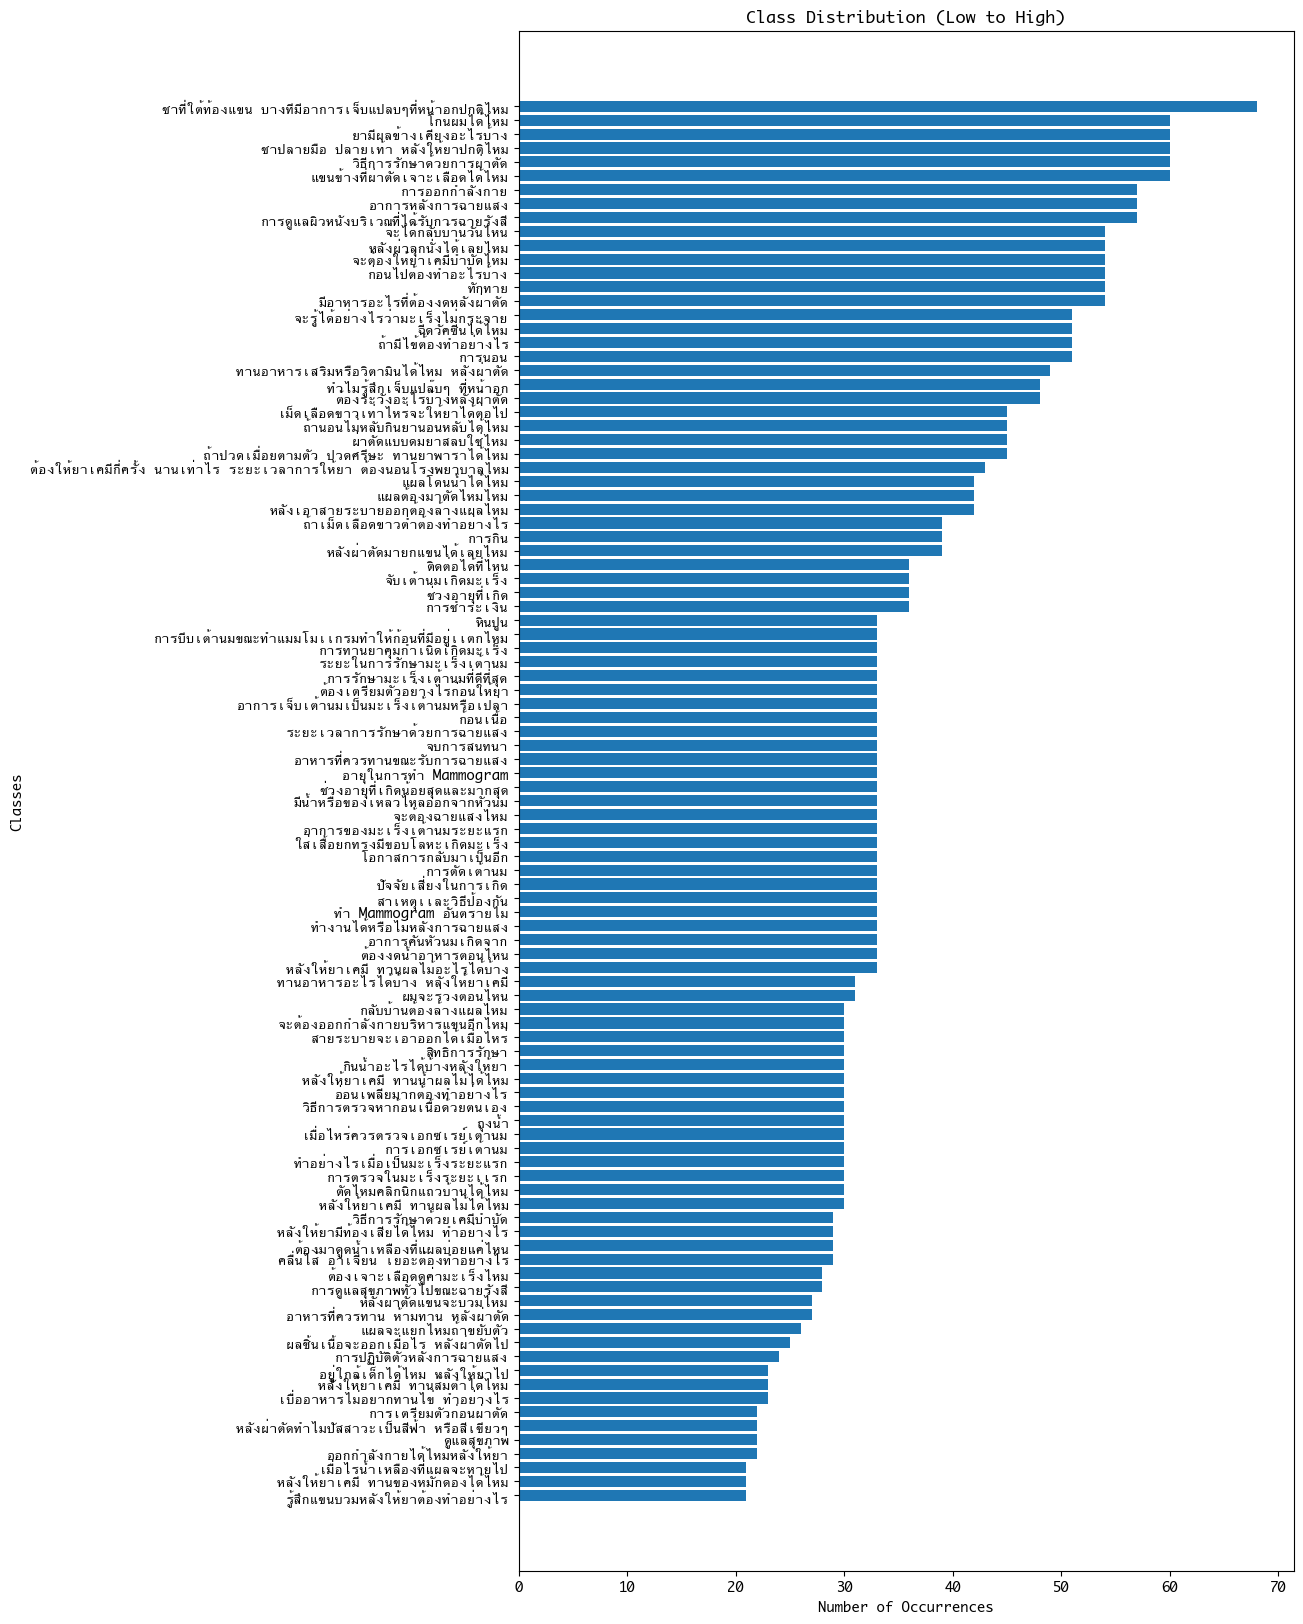

In [64]:
# count classes new
y_augmented = df_final['class']
class_counts_augmented = y_augmented.value_counts().sort_values(ascending=True)

class_counts_df_augmented = pd.DataFrame(class_counts_augmented).reset_index()
class_counts_df_augmented.columns = ['class', 'count_class']

# number of classes
print("number of classes: ", class_counts_df_augmented.shape[0])

# plot graph
import matplotlib

# Set the font that supports Thai 
matplotlib.rcParams['font.family'] = 'Ayuthaya'

# Plot graph
plt.figure(figsize=(10,20))
plt.barh(class_counts_df_augmented['class'], class_counts_df_augmented['count_class'])
plt.xlabel('Number of Occurrences')
plt.ylabel('Classes')
plt.title('Class Distribution (Low to High)')
plt.show()

In [63]:
# try build classification model using Bi-LSTM
from pythainlp.tokenize import word_tokenize
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Tokenize Thai text
X_tokenized = df_final['sentences'].apply(word_tokenize, keep_whitespace=False)
y = df_final['class']

# Step 1: Convert tokens to sequences of integers
word_to_index = {}
index = 1  # Start indexing from 1
for tokens in X_tokenized:
    for word in tokens:
        if word not in word_to_index:
            word_to_index[word] = index
            index += 1

# Convert tokenized sentences into integer sequences
tts = X_tokenized.apply(lambda tokens: [word_to_index[word] for word in tokens])

# Encode Labels
num_classes = len(np.unique(y)) 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert labels to numbers
y_categorical = to_categorical(y_encoded, num_classes=num_classes)  # Convert labels to one-hot encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tts, y_categorical, test_size=0.25, random_state=99)

# Find max length of the sentences for padding
maxlen = max([len(s) for s in tts])
print(f"Max sentence length = {maxlen}")

# Padding sequences to make them the same length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Define model parameters
embedding_dim = 50
vocab_size = len(word_to_index) + 1  # Adding 1 for padding token

# Build Bi-LSTM Model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

# Bidirectional LSTM Layer with Dropout and BatchNormalization
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# GlobalMaxPooling1D to reduce dimensions and keep the important features
model.add(GlobalMaxPooling1D())

# Dense Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (Softmax for classification)
model.add(Dense(num_classes, activation='softmax'))

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Add EarlyStopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=10,
                    validation_data=(X_test, y_test),
                    # callbacks=[early_stopping],
                    verbose=2)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {train_acc:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy: {test_acc:.4f}")


Max sentence length = 25
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


279/279 - 4s - 16ms/step - accuracy: 0.0205 - loss: 4.5930 - val_accuracy: 0.0366 - val_loss: 4.6067
Epoch 2/50
279/279 - 3s - 12ms/step - accuracy: 0.0431 - loss: 4.4731 - val_accuracy: 0.0807 - val_loss: 4.5433
Epoch 3/50
279/279 - 3s - 11ms/step - accuracy: 0.0661 - loss: 4.2939 - val_accuracy: 0.1399 - val_loss: 4.3541
Epoch 4/50
279/279 - 3s - 11ms/step - accuracy: 0.1157 - loss: 4.0530 - val_accuracy: 0.2379 - val_loss: 4.1235
Epoch 5/50
279/279 - 3s - 11ms/step - accuracy: 0.1692 - loss: 3.7523 - val_accuracy: 0.3671 - val_loss: 3.9085
Epoch 6/50
279/279 - 3s - 11ms/step - accuracy: 0.2202 - loss: 3.4435 - val_accuracy: 0.4747 - val_loss: 3.6107
Epoch 7/50
279/279 - 3s - 12ms/step - accuracy: 0.2705 - loss: 3.1110 - val_accuracy: 0.5619 - val_loss: 3.3158
Epoch 8/50
279/279 - 3s - 12ms/step - accuracy: 0.3384 - loss: 2.8161 - val_accuracy: 0.6372 - val_loss: 3.0515
Epoch 9/50
279/279 - 3s - 12ms/step - accuracy: 0.3818 - loss: 2.5234 - val_accuracy: 0.6900 - val_loss: 2.7838
Epo

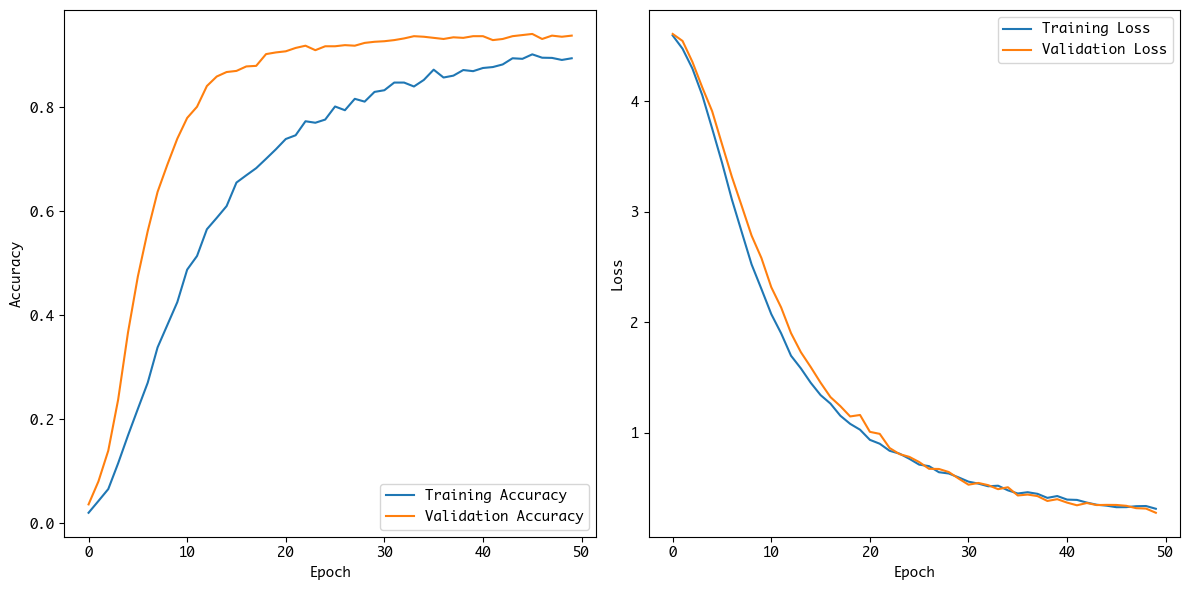

In [68]:
# Plot the accuracy and loss graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()